In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle
from tqdm import tqdm

from torchvision.models import resnet18

In [3]:
save_path = 'models/model_new_resnet.pt'
save_benchmark_path = 'models/model_new_benchmark_resnet.pt'
load_path = save_path
load_benchmark_path = save_benchmark_path

TRAIN=False
COMPUTE_INFO=False

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms["train"])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms["test"])

# Print number of samples in the dataset
print(f"Number of samples in the dataset: {len(dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Number of samples in the dataset: 50000


In [6]:
classes_name = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
import fisherunlearn
from fisherunlearn.clients_utils import generate_dirichlet_distributions
from fisherunlearn.clients_utils import split_dataset_by_class_distribution

num_clients = 5
target_client = 0
# Infer num_classes from your dataset or define it
targets = np.array(dataset.targets) # Assuming dataset is loaded
num_classes = int(np.max(targets)) + 1

alpha = 0.3 # For a non-IID distribution

dirichlet_distributions = generate_dirichlet_distributions(
    num_clients=num_clients,
    num_classes=num_classes,
    alpha=alpha,
    seed=42
)

print("Generated Dirichlet Distributions (Shape: {}):".format(dirichlet_distributions.shape))

print("\nSplitting dataset using the generated Dirichlet distributions...")
client_subsets_dirichlet = split_dataset_by_class_distribution(
    dataset=dataset, # Your loaded dataset
    class_distributions=dirichlet_distributions # Pass the generated matrix
)

classes_distributions = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    classes_distributions[i][i] = 1

classes_subsets = split_dataset_by_class_distribution(dataset, classes_distributions)

# Create dataloaders
client_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets_dirichlet]

benchmark_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets_dirichlet]
benchmark_dataloaders.pop(target_client)
target_dataloader = DataLoader(client_subsets_dirichlet[target_client], batch_size=64, shuffle=True)

classes_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=False) for subset in classes_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Generated Dirichlet Distributions (Shape: (5, 10)):

Splitting dataset using the generated Dirichlet distributions...


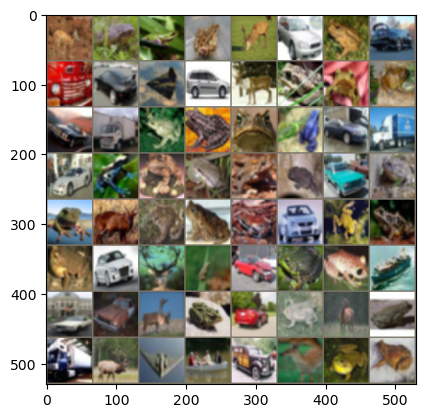

In [8]:
import torchvision
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(client_dataloaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[classes_name[x] for x in classes])

Total number of samples: 4041
Label distribution: {3: 553, 8: 1497, 2: 522, 0: 1233, 4: 145, 9: 64, 7: 26, 1: 1}


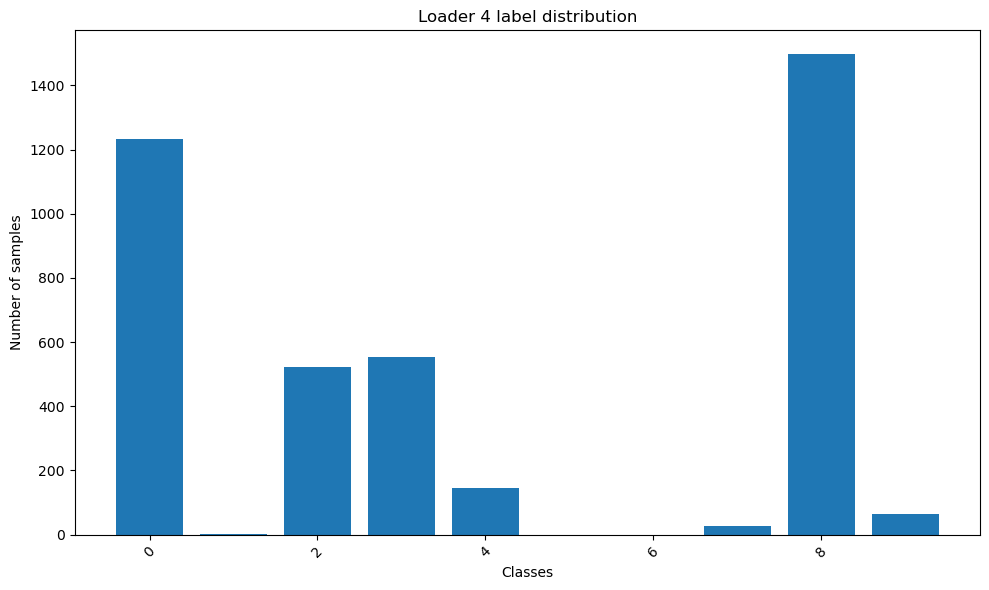

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import torch

def get_label_distribution(dataloader):
    label_counts = Counter()
    total_samples = 0

    # Add a try-except block to catch errors
    try:
        for _, labels in dataloader:
            # If labels is a tensor, convert to list first
            if isinstance(labels, torch.Tensor):
                # Flatten in case it's a 2D tensor
                labels_list = labels.flatten().tolist()
            else:
                labels_list = labels

            label_counts.update(labels_list)
            total_samples += len(labels_list)

    except Exception as e:
        print(f"Error occurred while iterating through dataloader: {e}")

    return dict(label_counts), total_samples

# Choose loader to visualize (assuming client_dataloaders is defined)
loader_idx = 4
try:
    loader = client_dataloaders[loader_idx]

    # Get the distribution
    label_distribution, total_samples = get_label_distribution(loader)

    print(f"Total number of samples: {total_samples}")
    print(f"Label distribution: {label_distribution}")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(list(label_distribution.keys()), list(label_distribution.values()))
    plt.xlabel('Classes')
    plt.ylabel('Number of samples')
    plt.title(f'Loader {loader_idx} label distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [10]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device

    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

In [11]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
def trainer(model, loss_fn, client_dataloaders, epochs, learning_rate=0.01, validation_loader=None, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    # Use SGD or Adam - Adam often requires lower initial LR
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001) # Adam Example

    # Example: Use StepLR - decays LR every N epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.05) # Decrease LR by factor of 0.1 every 10 epochs

    # Or, if using ReduceLROnPlateau, you MUST have a validation step:
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    for epoch in range(epochs):
        model.train() # Set model to training mode at the start of each epoch
        running_loss = 0.0
        total_samples = 0

        for client_loader in client_dataloaders:
            for imgs, labels in client_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                preds = model(imgs)
                loss = loss_fn(preds, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * imgs.size(0) # Accumulate loss weighted by batch size
                total_samples += imgs.size(0)

        epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
        print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {epoch_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # --- Scheduler Step ---
        # If using ReduceLROnPlateau, you'd need a validation step here:
        # if validation_loader:
        #     model.eval()
        #     val_loss = 0.0
        #     val_samples = 0
        #     with torch.no_grad():
        #         for v_imgs, v_labels in validation_loader:
        #             v_imgs, v_labels = v_imgs.to(device), v_labels.to(device)
        #             v_preds = model(v_imgs)
        #             v_loss = loss_fn(v_preds, v_labels)
        #             val_loss += v_loss.item() * v_imgs.size(0)
        #             val_samples += v_imgs.size(0)
        #     avg_val_loss = val_loss / val_samples if val_samples > 0 else 0.0
        #     print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")
        #     scheduler.step(avg_val_loss) # Step with validation loss
        # else:
        #     print("Warning: ReduceLROnPlateau scheduler used without validation_loader.")
        #     # Or handle differently if no validation loader provided

        # If using StepLR, CosineAnnealingLR, etc., call step without metric
        #scheduler.step()

    print("Training finished.")
    return model

# Save the model
def save_model_with_unique_name(model, base_path):
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(base_path)
    new_path = base_path
    counter = 1

    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    torch.save(model.state_dict(), new_path)
    print(f"Model saved to {new_path}")

In [12]:
# Model
model = resnet18(num_classes = 10, progress = True)
model_benchmark = resnet18(num_classes = 10)
loss_fn = nn.CrossEntropyLoss()

if TRAIN:
    model=trainer(model, loss_fn, client_dataloaders, epochs=100)
    save_model_with_unique_name(model, save_path)
    model_benchmark=trainer(model_benchmark, loss_fn, benchmark_dataloaders, epochs=100)
    save_model_with_unique_name(model_benchmark, save_benchmark_path)

else:
    model.load_state_dict(torch.load(load_path, weights_only=True))
    model_benchmark.load_state_dict(torch.load(load_benchmark_path, weights_only=True))

In [13]:
from backpack.extensions import DiagGGNExact
from backpack import extend, backpack
import copy

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagGGNExact()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_ggn_exact') and param.requires_grad:
            diag_hessian_params[name] = param.diag_ggn_exact.clone().detach()
            # Cleanup to avoid leftover references
            del param.diag_ggn_exact

    return diag_hessian_params

def compute_informations(model, criterion, dataloader_list):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = copy.deepcopy(model).to(device).eval()
    criterion = copy.deepcopy(criterion).to(device)
    model = extend(model, use_converter=True)
    criterion = extend(criterion)

    num_clients = len(dataloader_list)
    clients_hessians = []

    num_batches = sum(len(loader) for loader in dataloader_list)
    tqdm_bar = tqdm(total=num_batches, desc="Computing clients information", unit="batch")    

    for loader in dataloader_list:
        client_hessian = {}
        for inputs, targets in loader:
            # Compute the diag Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)

            # Accumulate avarage over batches
            for name, value in diag_h.items():
                if name not in client_hessian:
                    client_hessian[name] = value/(len(loader)*num_clients)
                else:
                    client_hessian[name] += value/(len(loader)*num_clients)
            tqdm_bar.update(1)

        clients_hessians.append(client_hessian)
    
    tqdm_bar.close()

    total_hessian = {}
    for name in clients_hessians[0].keys():
        total_hessian[name] = sum(client_hessian[name] for client_hessian in clients_hessians)

    
    clients_informations = []
    for client_idx in range(num_clients):
        client_info = {}
        for name in clients_hessians[client_idx].keys():
            layer_info = 0.5 * torch.pow(clients_hessians[client_idx][name]/total_hessian[name], 2)
            layer_info[total_hessian[name] == 0] = 0
            client_info[name] = layer_info.detach().cpu()
        clients_informations.append(client_info)
    
    return clients_informations


In [14]:
#from fisherunlearn import compute_informations

if COMPUTE_INFO:

    informations = compute_informations(model, loss_fn, client_dataloaders)

    with open('cached/informations.pkl', 'wb') as f:
            pickle.dump(informations, f)
else:
    with open('cached/informations.pkl', 'rb') as f:
        informations = pickle.load(f)

In [51]:
from fisherunlearn import find_informative_params, reset_parameters

info=informations[target_client]

whitelist = []
for name in info.keys():
    if "weight" in name:
        whitelist.append(name)

informative_params = find_informative_params(info, method='information', percentage=7, whitelist=whitelist, graph=False)

for name, params in informative_params.items():
    print(f"Layer: {name}, Parameters: {params.shape}")  # Print first 5 values for brevity
    

resetted_model = resnet18(num_classes = 10)

resetted_model.load_state_dict(reset_parameters(model, informative_params), strict=False)


Layer: conv1.weight, Parameters: torch.Size([336, 4])
Layer: bn1.weight, Parameters: torch.Size([1, 1])
Layer: layer1.0.conv1.weight, Parameters: torch.Size([401, 4])
Layer: layer1.0.bn1.weight, Parameters: torch.Size([1, 1])
Layer: layer1.0.conv2.weight, Parameters: torch.Size([282, 4])
Layer: layer1.0.bn2.weight, Parameters: torch.Size([2, 1])
Layer: layer1.1.conv1.weight, Parameters: torch.Size([130, 4])
Layer: layer1.1.bn1.weight, Parameters: torch.Size([0, 1])
Layer: layer1.1.conv2.weight, Parameters: torch.Size([139, 4])
Layer: layer1.1.bn2.weight, Parameters: torch.Size([2, 1])
Layer: layer2.0.conv1.weight, Parameters: torch.Size([331, 4])
Layer: layer2.0.bn1.weight, Parameters: torch.Size([3, 1])
Layer: layer2.0.conv2.weight, Parameters: torch.Size([743, 4])
Layer: layer2.0.bn2.weight, Parameters: torch.Size([3, 1])
Layer: layer2.0.downsample.0.weight, Parameters: torch.Size([126, 4])
Layer: layer2.0.downsample.1.weight, Parameters: torch.Size([4, 1])
Layer: layer2.1.conv1.weig

<All keys matched successfully>

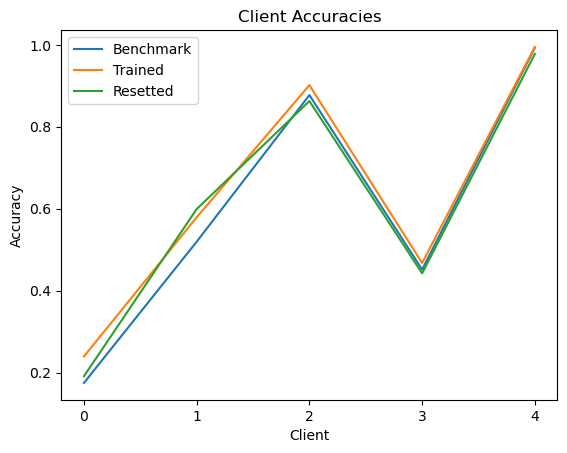

KeyboardInterrupt: 

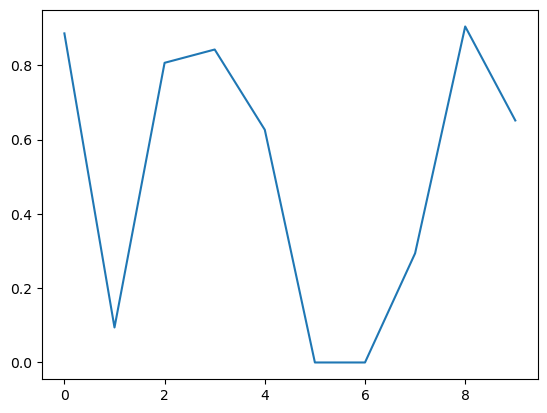

In [52]:

plt.plot(compute_dataloaders_accuracy(model_benchmark, client_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, client_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, client_dataloaders), label='Resetted')
plt.legend()
plt.xlabel('Client')
plt.xticks(np.arange(0, 5, 1))
plt.ylabel('Accuracy')
plt.title('Client Accuracies')
plt.show()

plt.plot(compute_dataloaders_accuracy(model_benchmark, classes_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, classes_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, classes_dataloaders), label='Resetted')
plt.legend()
plt.xlabel('Class')
plt.xticks(np.arange(0, 10, 1))
plt.ylabel('Accuracy')
plt.title('Classes Accuracies')
plt.show()


In [ ]:
print("Benchmark model test accuracy:")
print(compute_accuracy(model_benchmark, test_dataloader))
print("Trained model test accuracy:")
print(compute_accuracy(model, test_dataloader))
print("Resetted model test accuracy:")
print(compute_accuracy(resetted_model, test_dataloader))
print("Benchmark model target client accuracy:")
print(compute_accuracy(model_benchmark, target_dataloader))
print("Trained model target client accuracy:")
print(compute_accuracy(model, target_dataloader))
print("Resetted model target client accuracy:")
print(compute_accuracy(resetted_model, target_dataloader))

Benchmark model test accuracy:
0.1
Trained model test accuracy:


KeyboardInterrupt: 

Calculating benchmark accuracies (retrained_model)...
  Benchmark Global Test Accuracy: 0.1000
  Benchmark Target Client Accuracy: 0.1780


Processing Percentages:   0%|          | 0/21 [00:00<?, ?it/s]


Evaluating unlearning for different parameter percentages...

--- Processing Percentage: 0% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2169
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0389
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0765, LR: 0.001000
Training finished.


Processing Percentages:   5%|▍         | 1/21 [01:10<23:21, 70.09s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2518
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0738

--- Processing Percentage: 0% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2159
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0379
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0714, LR: 0.001000
Training finished.


Processing Percentages:  10%|▉         | 2/21 [02:20<22:14, 70.23s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2025
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0245

--- Processing Percentage: 0% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2154
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0374
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0705, LR: 0.001000
Training finished.


Processing Percentages:  14%|█▍        | 3/21 [03:29<20:55, 69.77s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2810
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.1030

--- Processing Percentage: 0% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2156
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0376
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0638, LR: 0.001000
Training finished.


Processing Percentages:  19%|█▉        | 4/21 [04:38<19:41, 69.52s/it]

  Retrained-from-Reset Global Test Accuracy: 0.0999
  Retrained-from-Reset Target Client Accuracy: 0.2639
  Delta Test Acc (Retrained - Benchmark): -0.0001
  Delta Target Acc (Retrained - Benchmark): 0.0859

--- Processing Percentage: 1% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2152
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0371
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0697, LR: 0.001000
Training finished.


Processing Percentages:  24%|██▍       | 5/21 [05:47<18:30, 69.38s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2647
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0867

--- Processing Percentage: 1% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2189
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0409
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0686, LR: 0.001000
Training finished.


Processing Percentages:  29%|██▊       | 6/21 [06:56<17:19, 69.28s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2407
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0626

--- Processing Percentage: 1% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2171
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0391
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0667, LR: 0.001000
Training finished.


Processing Percentages:  33%|███▎      | 7/21 [08:05<16:07, 69.10s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2535
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0755

--- Processing Percentage: 1% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2174
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0394
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0712, LR: 0.001000
Training finished.


Processing Percentages:  38%|███▊      | 8/21 [09:14<14:58, 69.11s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2934
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.1154

--- Processing Percentage: 2% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2132
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0352
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0598, LR: 0.001000
Training finished.


Processing Percentages:  43%|████▎     | 9/21 [10:24<13:49, 69.15s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1047
  Retrained-from-Reset Target Client Accuracy: 0.2642
  Delta Test Acc (Retrained - Benchmark): 0.0047
  Delta Target Acc (Retrained - Benchmark): 0.0862

--- Processing Percentage: 2% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2161
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0381
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0715, LR: 0.001000
Training finished.


Processing Percentages:  48%|████▊     | 10/21 [11:33<12:41, 69.27s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1043
  Retrained-from-Reset Target Client Accuracy: 0.2382
  Delta Test Acc (Retrained - Benchmark): 0.0043
  Delta Target Acc (Retrained - Benchmark): 0.0602

--- Processing Percentage: 2% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2171
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0391
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0693, LR: 0.001000
Training finished.


Processing Percentages:  52%|█████▏    | 11/21 [12:42<11:31, 69.14s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.1921
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0141

--- Processing Percentage: 2% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2179
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0399
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0637, LR: 0.001000
Training finished.


Processing Percentages:  57%|█████▋    | 12/21 [13:51<10:22, 69.11s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2575
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0795

--- Processing Percentage: 3% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2127
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0347
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0678, LR: 0.001000
Training finished.


Processing Percentages:  62%|██████▏   | 13/21 [15:00<09:12, 69.05s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2399
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0619

--- Processing Percentage: 3% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2137
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0357
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0715, LR: 0.001000
Training finished.


Processing Percentages:  67%|██████▋   | 14/21 [16:09<08:03, 69.01s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2364
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0584

--- Processing Percentage: 3% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2112
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0332
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0744, LR: 0.001000
Training finished.


Processing Percentages:  71%|███████▏  | 15/21 [17:18<06:54, 69.09s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2290
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0510

--- Processing Percentage: 3% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2119
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0339
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0642, LR: 0.001000
Training finished.


Processing Percentages:  76%|███████▌  | 16/21 [18:27<05:45, 69.17s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2738
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0958

--- Processing Percentage: 4% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2030
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0250
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0678, LR: 0.001000
Training finished.


Processing Percentages:  81%|████████  | 17/21 [19:37<04:36, 69.18s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1182
  Retrained-from-Reset Target Client Accuracy: 0.2503
  Delta Test Acc (Retrained - Benchmark): 0.0182
  Delta Target Acc (Retrained - Benchmark): 0.0723

--- Processing Percentage: 4% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2025
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0245
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0719, LR: 0.001000
Training finished.


Processing Percentages:  86%|████████▌ | 18/21 [20:46<03:27, 69.08s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1075
  Retrained-from-Reset Target Client Accuracy: 0.2194
  Delta Test Acc (Retrained - Benchmark): 0.0075
  Delta Target Acc (Retrained - Benchmark): 0.0413

--- Processing Percentage: 4% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2048
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0267
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0781, LR: 0.001000
Training finished.


Processing Percentages:  90%|█████████ | 19/21 [21:55<02:18, 69.12s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2109
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0329

--- Processing Percentage: 4% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2005
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): 0.0225
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0691, LR: 0.001000
Training finished.


Processing Percentages:  95%|█████████▌| 20/21 [23:04<01:09, 69.12s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1009
  Retrained-from-Reset Target Client Accuracy: 0.2293
  Delta Test Acc (Retrained - Benchmark): 0.0009
  Delta Target Acc (Retrained - Benchmark): 0.0513

--- Processing Percentage: 5% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.1698
  Delta Test Acc (Reset - Benchmark): 0.0000
  Delta Target Acc (Reset - Benchmark): -0.0082
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0746, LR: 0.001000
Training finished.


Processing Percentages: 100%|██████████| 21/21 [24:16<00:00, 69.36s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.2478
  Delta Test Acc (Retrained - Benchmark): 0.0000
  Delta Target Acc (Retrained - Benchmark): 0.0698

Plotting results...


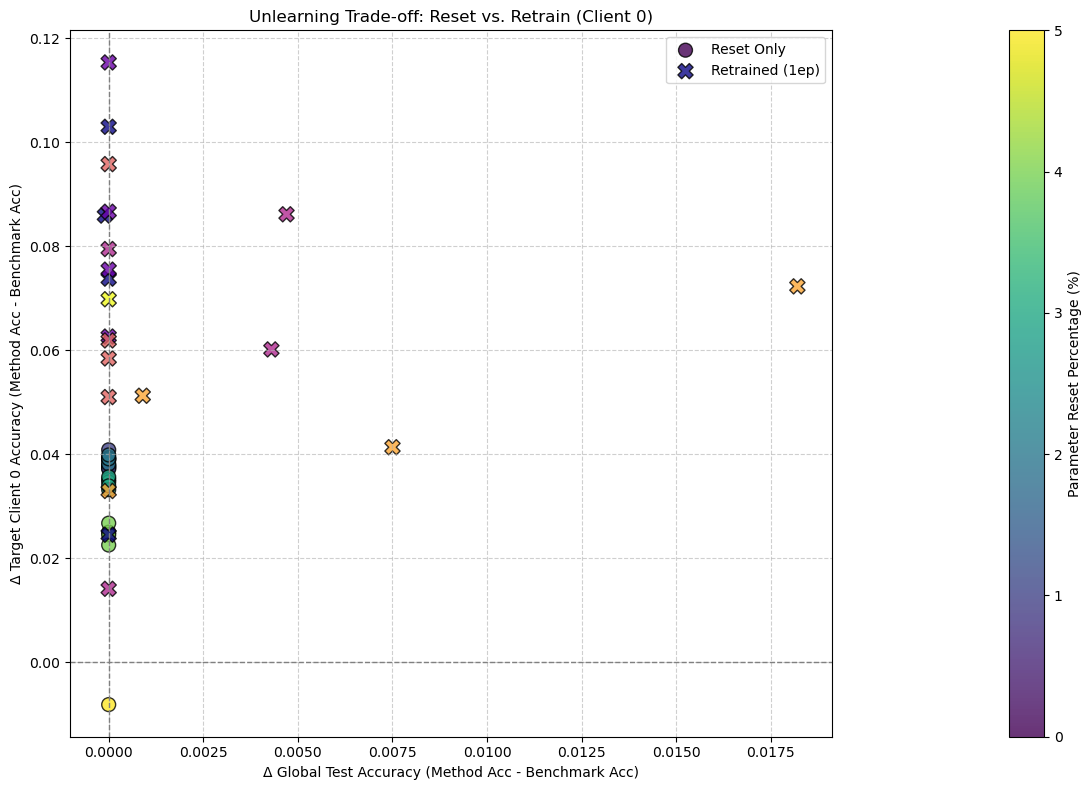


Computed Deltas:
{'delta_test_accuracies_reset': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'delta_target_accuracies_reset': [0.0388710076751671, 0.03788066353057687, 0.03738549145828174, 0.03763307749442929, 0.03713790542213419, 0.040851695964347595, 0.03911859371131468, 0.03936617974746223, 0.035157217132953694, 0.03812824956672442, 0.03911859371131468, 0.03986135181975736, 0.034662045060658564, 0.035652389205248824, 0.0331765288437732, 0.03391928695221588, 0.025006189650903676, 0.024511017578608546, 0.02673929190393662, 0.022530329289428053, -0.008170339192869525], 'delta_test_accuracies_retrained': [0.0, 0.0, 0.0, -0.00010000000000000286, 0.0, 0.0, 0.0, 0.0, 0.004699999999999996, 0.004299999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018199999999999994, 0.007499999999999993, 0.0, 0.000899999999999998, 0.0], 'delta_target_accuracies_retrained': [0.07378063877197327, 0.024511017578608546, 0.10299579103738549, 0.085912354

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from typing import Callable, Dict, List, Optional, Any, Union

class UnlearningTradeoffPlotter:
    """
    Computes and plots the unlearning trade-off graph.

    Compares the drop in accuracy on a global test set vs. the drop in accuracy
    on the target client's data for various parameter reset percentages. Plots results
    for both the reset-only model and a model retrained after resetting. Deltas
    are calculated relative to a benchmark 'retrained_model'.
    """
    def __init__(
        self,
        # Models & Data
        original_model: torch.nn.Module,
        retrained_model: torch.nn.Module, # Benchmark model (e.g., model_benchmark)
        informations: Dict[Any, Dict[str, torch.Tensor]],
        target_client: Any,
        target_client_dataloader: torch.utils.data.DataLoader,
        global_test_dataloader: torch.utils.data.DataLoader,
        benchmark_dataloaders: List[torch.utils.data.DataLoader], # DataLoaders excluding target_client

        # Core Functions & Model Arch
        model_architecture_fn: Callable[..., torch.nn.Module],
        model_init_args: Dict[str, Any],
        find_informative_params_fn: Callable[..., List[str]],
        reset_parameters_fn: Callable[..., Dict[str, torch.Tensor]],
        compute_accuracy_fn: Callable[..., float],
        trainer_fn: Callable[..., torch.nn.Module], # Your trainer function
        loss_fn_retrain: nn.Module, # Loss function for retraining step

        # Configuration
        epochs_retrain: int = 1, # Epochs for retraining after reset
        device: Optional[Union[str, torch.device]] = None,
        verbose: bool = True
    ):
        """
        Initializes the plotter with models, data, and functions.
        """
        self.original_model = original_model.cpu() # Keep original on CPU
        self.retrained_model = retrained_model
        self.informations = informations
        self.target_client = target_client
        self.target_client_dataloader = target_client_dataloader
        self.global_test_dataloader = global_test_dataloader
        self.benchmark_dataloaders = benchmark_dataloaders # Data for retraining

        self.model_architecture_fn = model_architecture_fn
        self.model_init_args = model_init_args
        self.find_informative_params_fn = find_informative_params_fn
        self.reset_parameters_fn = reset_parameters_fn
        self.compute_accuracy_fn = compute_accuracy_fn
        self.trainer_fn = trainer_fn # Store trainer function
        self.loss_fn_retrain = loss_fn_retrain # Store loss for retraining
        self.epochs_retrain = epochs_retrain # Store epochs for retraining

        self.verbose = verbose

        if device is None:
            self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self._device = torch.device(device)

        # Results storage
        self.delta_test_accuracies_reset: List[float] = []
        self.delta_target_accuracies_reset: List[float] = []
        self.delta_test_accuracies_retrained: List[float] = []
        self.delta_target_accuracies_retrained: List[float] = []
        self.param_percentages_tested: Optional[np.ndarray] = None

        # Calculate benchmark accuracies once
        self._calculate_benchmark_accuracies()

    def _calculate_benchmark_accuracies(self):
        """Computes and stores benchmark accuracies."""
        if self.verbose: print("Calculating benchmark accuracies (retrained_model)...")
        self.retrained_model.to(self._device)
        self.retrained_test_acc = self.compute_accuracy_fn(
            self.retrained_model, self.global_test_dataloader, device=self._device
        )
        self.retrained_target_acc = self.compute_accuracy_fn(
            self.retrained_model, self.target_client_dataloader, device=self._device
        )
        # Optional: Move back to CPU
        # self.retrained_model.cpu()
        if self.verbose:
            print(f"  Benchmark Global Test Accuracy: {self.retrained_test_acc:.4f}")
            print(f"  Benchmark Target Client Accuracy: {self.retrained_target_acc:.4f}")

    # In class UnlearningTradeoffPlotter:

    def compute_deltas(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None
    ) -> Dict[str, List[float]]:
        """
        Computes the accuracy deltas (Unlearned Acc - Benchmark Acc) for the
        specified percentages for both reset-only and retrained-from-reset models.

        Args:
            param_percentages: List/array of percentages (0-100). Defaults to [0, 10,..., 100].

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        if param_percentages is None:
            self.param_percentages_tested = np.linspace(0, 100, 11).astype(int)
        else:
            self.param_percentages_tested = np.array(param_percentages)

        # Reset results lists
        self.delta_test_accuracies_reset = []
        self.delta_target_accuracies_reset = []
        self.delta_test_accuracies_retrained = []
        self.delta_target_accuracies_retrained = []

        try:
            info = self.informations[self.target_client]
        except KeyError:
            raise ValueError(f"Target client '{self.target_client}' not found in informations dict.")

        iterator = tqdm(self.param_percentages_tested, desc="Processing Percentages") if self.verbose else self.param_percentages_tested
        if self.verbose: print("\nEvaluating unlearning for different parameter percentages...")

        for perc in iterator:
            if self.verbose: print(f"\n--- Processing Percentage: {perc}% ---")

            resetted_model = None
            retrained_from_reset_model = None

            try:
                # --- Reset Step ---
                informative_params = self.find_informative_params_fn(
                    info, method='information', percentage=perc, graph=False
                )
                if self.verbose: print(f"  Found {len(informative_params)} informative parameter names.")
                
                resetted_model = self.model_architecture_fn(**self.model_init_args)
                resetted_state_dict = self.reset_parameters_fn(self.original_model, informative_params)
                resetted_model.load_state_dict(resetted_state_dict, strict=True)
                resetted_model.to(self._device)


                # Evaluate Reset-Only Model
                reset_test_acc = self.compute_accuracy_fn(resetted_model, self.global_test_dataloader, device=self._device)
                reset_target_acc = self.compute_accuracy_fn(resetted_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Reset-Only Global Test Accuracy: {reset_test_acc:.4f}")
                    print(f"  Reset-Only Target Client Accuracy: {reset_target_acc:.4f}")

                # --- Calculate Deltas for Reset-Only (Unlearned - Benchmark) ---
                delta_test_reset = reset_test_acc - self.retrained_test_acc      # Swapped
                delta_target_reset = reset_target_acc - self.retrained_target_acc  # Swapped
                self.delta_test_accuracies_reset.append(delta_test_reset)
                self.delta_target_accuracies_reset.append(delta_target_reset)
                if self.verbose:
                    # Updated print statement description
                    print(f"  Delta Test Acc (Reset - Benchmark): {delta_test_reset:.4f}")
                    print(f"  Delta Target Acc (Reset - Benchmark): {delta_target_reset:.4f}")

                # --- Retrain Step ---
                if self.verbose: print(f"  Retraining from reset for {self.epochs_retrain} epoch(s)...")

                retrained_from_reset_model = self.trainer_fn(
                    model=resetted_model,
                    loss_fn=self.loss_fn_retrain,
                    client_dataloaders=self.benchmark_dataloaders,
                    epochs=self.epochs_retrain
                )
                retrained_from_reset_model.to(self._device)


                # Evaluate Retrained-from-Reset Model
                retrained_r_test_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.global_test_dataloader, device=self._device)
                retrained_r_target_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Retrained-from-Reset Global Test Accuracy: {retrained_r_test_acc:.4f}")
                    print(f"  Retrained-from-Reset Target Client Accuracy: {retrained_r_target_acc:.4f}")

                # --- Calculate Deltas for Retrained-from-Reset (Unlearned - Benchmark) ---
                delta_test_retrained = retrained_r_test_acc - self.retrained_test_acc      # Swapped
                delta_target_retrained = retrained_r_target_acc - self.retrained_target_acc  # Swapped
                self.delta_test_accuracies_retrained.append(delta_test_retrained)
                self.delta_target_accuracies_retrained.append(delta_target_retrained)
                if self.verbose:
                     # Updated print statement description
                    print(f"  Delta Test Acc (Retrained - Benchmark): {delta_test_retrained:.4f}")
                    print(f"  Delta Target Acc (Retrained - Benchmark): {delta_target_retrained:.4f}")

            except Exception as e:
                print(f"\nERROR processing percentage {perc}: {e}")
                self.delta_test_accuracies_reset.append(float('nan'))
                self.delta_target_accuracies_reset.append(float('nan'))
                self.delta_test_accuracies_retrained.append(float('nan'))
                self.delta_target_accuracies_retrained.append(float('nan'))

            finally:
                final_resetted_ref = resetted_model
                final_retrained_ref = retrained_from_reset_model
                if final_retrained_ref is not None and final_resetted_ref is not None and final_retrained_ref is not final_resetted_ref:
                    del retrained_from_reset_model
                    final_retrained_ref = None
                if final_resetted_ref is not None:
                    del resetted_model
                    final_resetted_ref = None
                if self._device.type == 'cuda':
                   torch.cuda.empty_cache()


        results = {
            'delta_test_accuracies_reset': self.delta_test_accuracies_reset,
            'delta_target_accuracies_reset': self.delta_target_accuracies_reset,
            'delta_test_accuracies_retrained': self.delta_test_accuracies_retrained,
            'delta_target_accuracies_retrained': self.delta_target_accuracies_retrained,
            'param_percentages': list(self.param_percentages_tested)
        }
        return results

    def plot(
        self,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ):
        """
        Generates the trade-off plot showing both reset-only and retrained results.

        Args:
            plot_kwargs_reset: Dict of keyword arguments for reset-only plt.scatter.
            plot_kwargs_retrained: Dict of keyword arguments for retrained plt.scatter.
            show_plot: If True, displays the plot using plt.show().
            title_suffix: Optional string to append to the plot title.
        """
        if not self.delta_test_accuracies_reset or self.param_percentages_tested is None:
            raise RuntimeError("Deltas have not been computed. Call compute_deltas() first.")

        if plot_kwargs_reset is None: plot_kwargs_reset = {}
        if plot_kwargs_retrained is None: plot_kwargs_retrained = {}

        if self.verbose: print("\nPlotting results...")
        plt.figure(figsize=(11, 8))

        # --- Plot Reset-Only Results ---
        scatter_defaults_reset = {
            'c': self.param_percentages_tested, 'cmap': 'viridis', 's': 100,
            'alpha': 0.8, 'edgecolors': 'k', 'marker': 'o', 'label': 'Reset Only'
        }
        scatter_defaults_reset.update(plot_kwargs_reset)
        scatter1 = plt.scatter(
            self.delta_test_accuracies_reset,
            self.delta_target_accuracies_reset,
            **scatter_defaults_reset
        )

        # --- Plot Retrained-from-Reset Results ---
        scatter_defaults_retrained = {
             'c': self.param_percentages_tested, 'cmap': 'plasma', 's': 120,
             'alpha': 0.8, 'edgecolors': 'k', 'marker': 'X', 'label': f'Retrained ({self.epochs_retrain}ep)'
        }
        scatter_defaults_retrained.update(plot_kwargs_retrained)
        scatter2 = plt.scatter(
            self.delta_test_accuracies_retrained,
            self.delta_target_accuracies_retrained,
            **scatter_defaults_retrained
        )

        # Add annotations
        """ for i, perc in enumerate(self.param_percentages_tested):
             perc_label = f"{int(perc) if perc == int(perc) else perc:.1f}%"
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_reset[i], self.delta_target_accuracies_reset[i]),
                          textcoords="offset points", xytext=(-10, 10),
                          ha='center', fontsize=9, color='darkgreen')
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_retrained[i], self.delta_target_accuracies_retrained[i]),
                          textcoords="offset points", xytext=(10, -15),
                          ha='center', fontsize=9, color='darkred')
 """
        plt.colorbar(scatter1, label='Parameter Reset Percentage (%)', location='right', anchor=(1.2, 0.5))

        # --- UPDATED AXIS LABELS ---
        plt.xlabel('Δ Global Test Accuracy (Method Acc - Benchmark Acc)')
        plt.ylabel(f'Δ Target Client {self.target_client} Accuracy (Method Acc - Benchmark Acc)')
        plt.title(f'Unlearning Trade-off: Reset vs. Retrain (Client {self.target_client}){title_suffix}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(0, color='grey', lw=1.0, linestyle='--')
        plt.axvline(0, color='grey', lw=1.0, linestyle='--')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig("prova_resnet.png")

        if show_plot:
            plt.show()

    def run(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ) -> Dict[str, List[float]]:
        """
        Runs both delta computation and plotting for reset and retrained models.

        Args:
            (See compute_deltas and plot methods for argument details)

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        results = self.compute_deltas(param_percentages)
        self.plot(
            plot_kwargs_reset=plot_kwargs_reset,
            plot_kwargs_retrained=plot_kwargs_retrained,
            show_plot=show_plot,
            title_suffix=title_suffix
        )
        return results


loss_retrain = nn.CrossEntropyLoss() # Define the loss for the retraining step

plotter = UnlearningTradeoffPlotter(
    # Models & Data
    original_model=model,
    retrained_model=model_benchmark, # Benchmark model
    informations=informations,
    target_client=target_client,
    target_client_dataloader=target_dataloader,
    global_test_dataloader=test_dataloader,
    benchmark_dataloaders=benchmark_dataloaders, # DataLoaders excluding target_client

    # Core Functions & Model Arch
    model_architecture_fn=resnet18,
    model_init_args={'num_classes': num_classes},
    find_informative_params_fn=find_informative_params,
    reset_parameters_fn=reset_parameters,
    compute_accuracy_fn=compute_accuracy,
    trainer_fn=trainer, # Your trainer function
    loss_fn_retrain=loss_retrain, # Loss for retraining step

    # Configuration
    epochs_retrain=1, # Epochs for retraining after reset
    device=None,
    verbose=True
)

# Run computation and plotting
results = plotter.run(param_percentages=np.linspace(0, 5, 21).astype(int)) 

print("\nComputed Deltas:")
print(results)